# Homework 02: Multi-Class Classification with Neural Networks

## Due: Midnight on September 14 (with 2-hour grace period) and worth 85 points

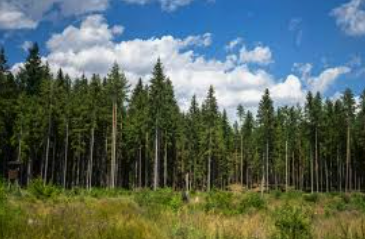

In this assignment, you’ll extend your Keras classification toolkit by training a neural network on a **balanced subset of the Forest Cover (Covertype) dataset**. We’ll begin with a simple baseline network, then study how performance changes as we vary **batch size**, **learning rate**, and apply a **cosine-decay schedule**.

For each configuration, you will consider a range of hyperparameter values, plot training/validation **loss** and **accuracy** over epochs, and determine which choice gave the best performance. 

Finally, you will consider all that you have learned and build your best model and run it on the test set. 


There are 9 graded questions, each worth 9 points, and you get 4 points for free if you complete the whole homework. 


In [1]:
pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 21.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 6.1 MB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 46.3 MB/s eta 0:00:00:00:01
   ━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  1/25 [libclang]  WARNING: The script wheel is installed in '/usr/local/python/3.12.1/bin' which is not on PATH.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
   ━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━ 13/25 [markdown]m]-data-server]  WARNIN

In [2]:
# Useful imports

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_covtype

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay

random_seed = 42

tf.random.set_seed(random_seed)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages

2025-09-14 22:28:54.316768: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-14 22:28:55.417222: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-14 22:28:59.131108: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [3]:
# Utility function: Plotting Training Loss (categorical x-entropy) and Accuracy

# Takes the history object returned by fit

def plot_history(history):
    n_epochs = len(history.history['accuracy'])
    epochs = range(1, n_epochs + 1)

    plt.figure(figsize=(7, 8))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss (Xent)', color='tab:red')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', color='tab:blue')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.05)
    plt.title('Training Accuracy')
    plt.grid(True)
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

    final_loss = history.history['loss'][-1]
    final_acc = history.history['accuracy'][-1]
    print(f'Final Training Loss:     {final_loss:.4f}')
    print(f'Final Training Accuracy: {final_acc:.4f}')

## Load the dataset

The dataset is described in detail in the Appendix. For the purposes of this homework, we are selecting a random sample with 2747 samples in each class (to preserve balance), because the original dataset is both very large and very imbalanced, with the smallest class having 2747 samples. 

In [4]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter
import numpy as np

# Load
X, y = fetch_covtype(return_X_y=True)   # y in {1..7}
classes, counts = np.unique(y, return_counts=True)
min_count = counts.min()                # size of rarest class (~2.7k)

# Build perfectly balanced subset (no replacement, no duplicates)
rng = np.random.default_rng(42)
idx_list = []
for c in classes:
    c_idx = np.where(y == c)[0]
    chosen = rng.choice(c_idx, size=min_count, replace=False)
    idx_list.append(chosen)

idx_bal = np.concatenate(idx_list)
rng.shuffle(idx_bal)

X_sub = X[idx_bal]
y_sub = y[idx_bal] - 1                  # relabel to 0..6 for Keras
print("Subset shape:", X_sub.shape, "Class counts:", Counter(y_sub))


Subset shape: (19229, 54) Class counts: Counter({np.int32(3): 2747, np.int32(2): 2747, np.int32(6): 2747, np.int32(5): 2747, np.int32(4): 2747, np.int32(1): 2747, np.int32(0): 2747})


## Problem One: Prepare the dataset and build a baseline model

### Part A: Stratified train/test split and standardization

As in Homework 1, follow these three steps:

1. **Stratified split:**
   Use `train_test_split` with `stratify=y_sub` to preserve class proportions in both training and test sets. Be sure to set `random_state=random_seed` and `test_size=0.2`.

2. **Standardize features:**
   Scale the input features so they have mean 0 and variance 1.



In [29]:
# Your code here

X_train, X_test, y_train, y_test = train_test_split(
    X_sub, y_sub, 
    test_size=0.2, 
    stratify=y_sub, 
    random_state=random_seed
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test labels shape: {y_test.shape}")

print("\nClass distribution in training set:")
print(Counter(y_train))
print("\nClass distribution in test set:")
print(Counter(y_test))

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nOriginal training data - Mean: {X_train.mean():.4f}, Std: {X_train.std():.4f}")
print(f"Scaled training data - Mean: {X_train_scaled.mean():.4f}, Std: {X_train_scaled.std():.4f}")

print(f"\nOriginal test data - Mean: {X_test.mean():.4f}, Std: {X_test.std():.4f}")  
print(f"Scaled test data - Mean: {X_test_scaled.mean():.4f}, Std: {X_test_scaled.std():.4f}")

print(f"\nFinal shapes after standardization:")
print(f"X_train_scaled: {X_train_scaled.shape}")
print(f"X_test_scaled: {X_test_scaled.shape}")

Training set shape: (15383, 54)
Test set shape: (3846, 54)
Training labels shape: (15383,)
Test labels shape: (3846,)

Class distribution in training set:
Counter({np.int32(5): 2198, np.int32(1): 2198, np.int32(0): 2198, np.int32(2): 2198, np.int32(6): 2197, np.int32(3): 2197, np.int32(4): 2197})

Class distribution in test set:
Counter({np.int32(3): 550, np.int32(4): 550, np.int32(6): 550, np.int32(1): 549, np.int32(0): 549, np.int32(5): 549, np.int32(2): 549})

Original training data - Mean: 129.9836, Std: 533.9955
Scaled training data - Mean: -0.0000, Std: 0.9907

Original test data - Mean: 130.1533, Std: 534.8479
Scaled test data - Mean: 0.0008, Std: 1.0352

Final shapes after standardization:
X_train_scaled: (15383, 54)
X_test_scaled: (3846, 54)


### Part B: Build, compile, train, and evaluate the network

1. **Build the model**

   * Use 2 hidden layers:  input &rarr; 64 &rarr; 32 &rarr; output.
   * Apply the `relu` activation for the hidden layers and `softmax` for the output layer.

2. **Compile the model**

    * Use the following parameters


           optimizer = Adam(learning_rate=0.0001),  
           loss = 'sparse_categorical_crossentropy',  
           metrics = ['accuracy']


4. **Train the model**

   * Run for **20 epochs**.
   * Use a `batch_size` of 32.

5. **Evaluate training**

   * Plot the training loss and accuracy curves using `plot_history`.

6. **Answer the graded questions**



Model architecture:


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)


Model compiled successfully!

Starting training...
Epoch 1/20


481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3606 - loss: 1.7494 - val_accuracy: 0.5354 - val_loss: 1.4534
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5700 - loss: 1.2562 - val_accuracy: 0.5996 - val_loss: 1.0997
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6098 - loss: 1.0240 - val_accuracy: 0.6292 - val_loss: 0.9497
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6292 - loss: 0.9284 - val_accuracy: 0.6516 - val_loss: 0.8807
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6458 - loss: 0.8786 - val_accuracy: 0.6664 - val_loss: 0.8397
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6572 - loss: 0.8454 - val_accuracy: 0.6765 - val_loss: 0.8103
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6665 - loss: 0.8198 - val_accuracy: 0.6875 - val_loss: 0.7869
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6767 - loss: 0.7985 - val_accuracy: 0.6992 - val_

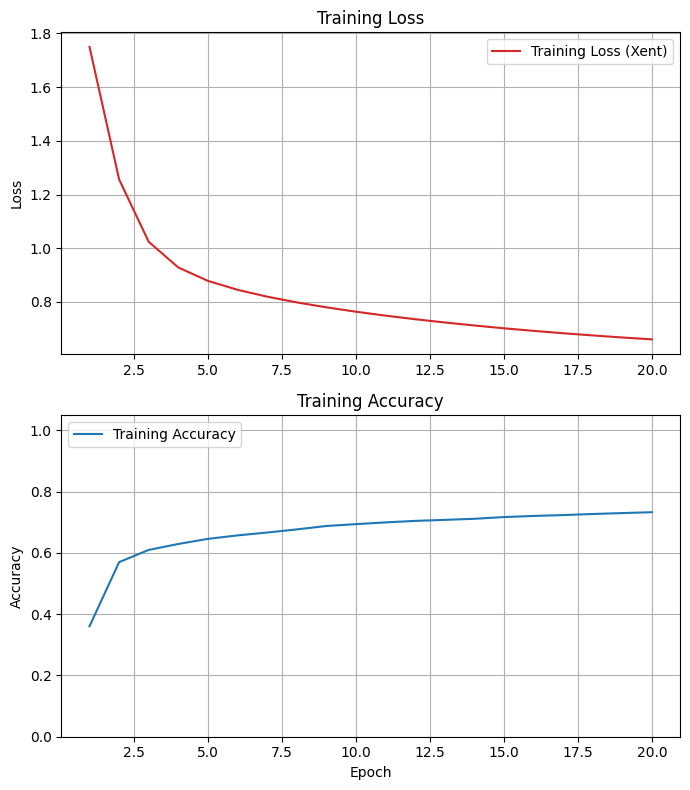

Final Training Loss:     0.6608
Final Training Accuracy: 0.7329

Final training accuracy at epoch 20: 0.7329


In [30]:
# Your code here

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(7, activation='softmax')  
])

print("Model architecture:")
model.summary()

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel compiled successfully!")

print("\nStarting training...")

history = model.fit(
    X_train_scaled, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_scaled, y_test),
    verbose=1
)

print("Training completed!")
print("\nPlotting training history...")
plot_history(history)

final_training_accuracy = history.history['accuracy'][-1]
print(f"\nFinal training accuracy at epoch 20: {final_training_accuracy:.4f}")

In [31]:
# Set a1a to the final training accuracy at epoch 20

a1a = 0.7329             # Replace 0.0 with your answer

In [32]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1a = {a1a:.4f}')  

a1a = 0.7329


## Problem Two: Batch Sizes

Next, we’ll explore how the **batch size** affects training. .

* Start with the code from Problem One.
* Run **four experiments** using a batch size of 4, 8, 16, and 128, and  displaying the results using `plot_history`.

* Answer the graded questions.

**Note:** Consider using a `for` loop!

Starting batch size experiments...

Experiment with batch_size = 4
------------------------------
Epoch 1/20


3846/3846 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.4830 - loss: 1.3888 - val_accuracy: 0.6290 - val_loss: 0.9801
Epoch 2/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6468 - loss: 0.8861 - val_accuracy: 0.6719 - val_loss: 0.8085
Epoch 3/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.6818 - loss: 0.7856 - val_accuracy: 0.6932 - val_loss: 0.7406
Epoch 4/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.6993 - loss: 0.7356 - val_accuracy: 0.7129 - val_loss: 0.7009
Epoch 5/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.7121 - loss: 0.7025 - val_accuracy: 0.7244 - val_loss: 0.6737
Epoch 6/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.7225 - loss: 0.6780 - val_accuracy: 0.7311 - val_loss: 0.6529
Epoch 7/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7299 - loss: 0.6583 - val_accuracy: 0.7384 - val_loss: 0.6358
Epoch 8/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7360 - loss: 0.6416 - val_accur

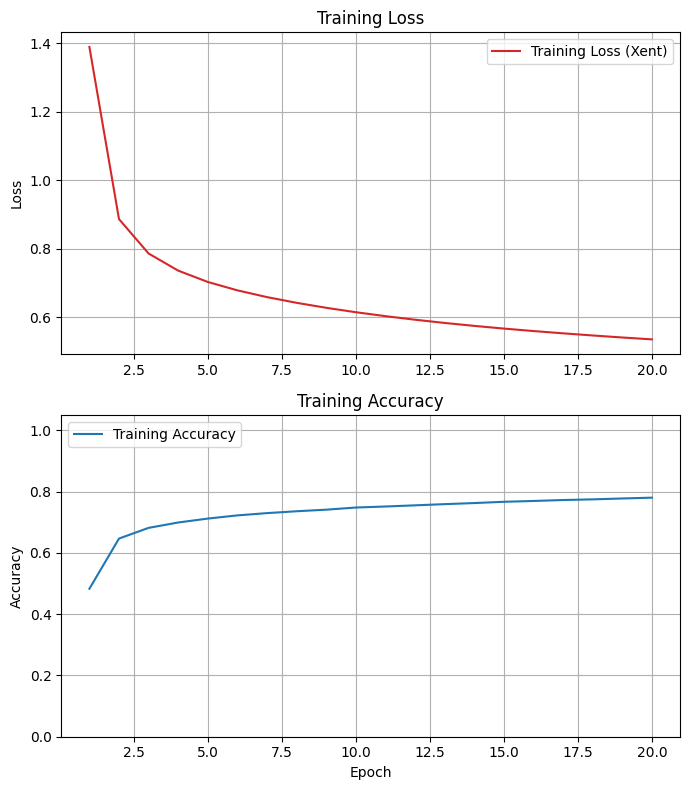

Final Training Loss:     0.5349
Final Training Accuracy: 0.7803

Plots for batch_size = 8:


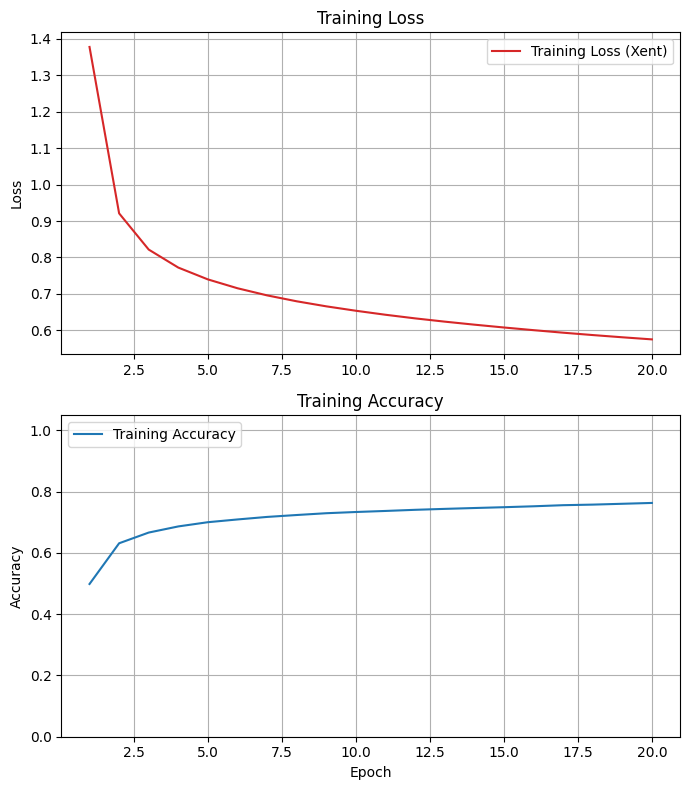

Final Training Loss:     0.5751
Final Training Accuracy: 0.7631

Plots for batch_size = 16:


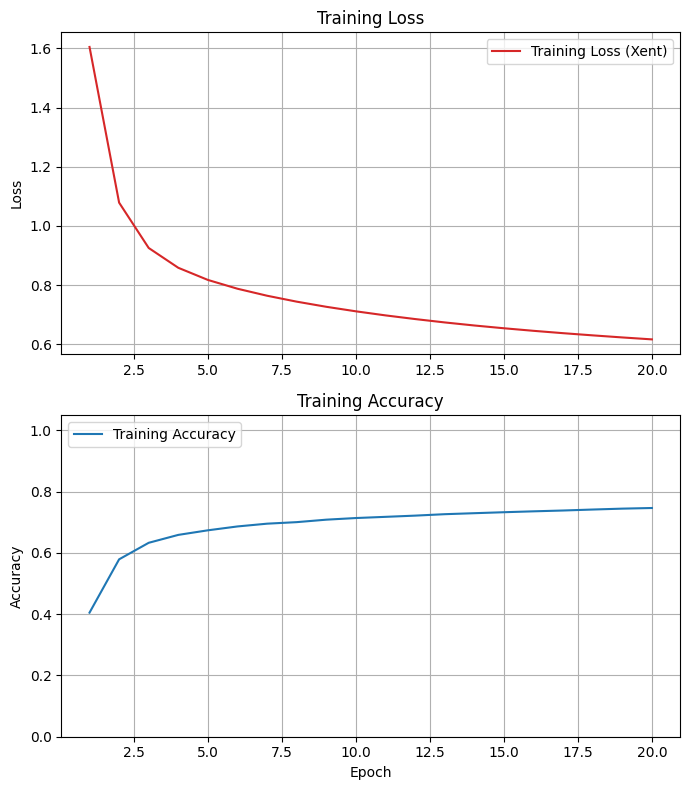

Final Training Loss:     0.6167
Final Training Accuracy: 0.7466

Plots for batch_size = 128:


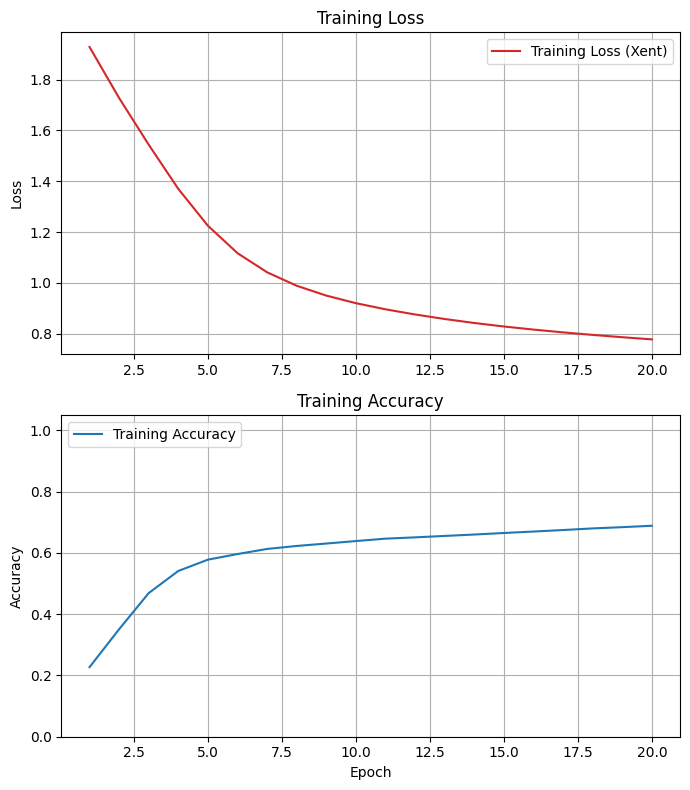

Final Training Loss:     0.7777
Final Training Accuracy: 0.6886

SUMMARY OF RESULTS
Batch size   4: Final accuracy = 0.7803
Batch size   8: Final accuracy = 0.7631
Batch size  16: Final accuracy = 0.7466
Batch size 128: Final accuracy = 0.6886

Best performing batch size: 4
Best accuracy score: 0.7803


In [33]:
# Your code here

batch_sizes = [4, 8, 16, 128]

results = {}
histories = {}
final_accuracies = {}

print("Starting batch size experiments...")
print("=" * 50)

for batch_size in batch_sizes:
    print(f"\nExperiment with batch_size = {batch_size}")
    print("-" * 30)
    
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dense(32, activation='relu'),
        Dense(7, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    history = model.fit(
        X_train_scaled, y_train,
        epochs=20,
        batch_size=batch_size,
        validation_data=(X_test_scaled, y_test),
        verbose=1
    )
    
    histories[batch_size] = history
    final_accuracy = history.history['accuracy'][-1]
    final_accuracies[batch_size] = final_accuracy
    
    print(f"Final training accuracy for batch_size {batch_size}: {final_accuracy:.4f}")

print("\n" + "=" * 50)
print("All experiments completed!")

print("\nPlotting training histories for all batch sizes...")
for batch_size in batch_sizes:
    print(f"\nPlots for batch_size = {batch_size}:")
    plot_history(histories[batch_size])

best_batch_size = max(final_accuracies, key=final_accuracies.get)
best_accuracy = final_accuracies[best_batch_size]

print("\n" + "=" * 50)
print("SUMMARY OF RESULTS")
print("=" * 50)
for batch_size in batch_sizes:
    accuracy = final_accuracies[batch_size]
    print(f"Batch size {batch_size:3d}: Final accuracy = {accuracy:.4f}")

print(f"\nBest performing batch size: {best_batch_size}")
print(f"Best accuracy score: {best_accuracy:.4f}")

In [34]:
# Set a2a to the batch size which produced the best accuracy score at epoch 20

a2a = 4             # Replace 0 with your answer

In [35]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2a = {a2a}') 

a2a = 4


In [36]:
# Set a2b to the best accuracy score found

a2b = 0.7803             # Replace 0.0 with your answer

In [37]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2b = {a2b:.4f}') 

a2b = 0.7803


## Problem Three: Learning Rates

Next, we’ll explore how the **learning rate** affects training when using the Adam optimizer.

* Start with the code from **Problem One**.
* Add the `learning_rate` parameter to `Adam`.
* Run **five experiments** using the following values:

        [1e-3, 5e-4, 1e-4,5e-5, 1e-5]

* Display your results using `plot_history` and answer the graded questions.


Starting learning rate experiments...

Experiment with learning_rate = 0.001
----------------------------------------
Epoch 1/20


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5986 - loss: 1.0277 - val_accuracy: 0.6890 - val_loss: 0.7625
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6928 - loss: 0.7398 - val_accuracy: 0.7291 - val_loss: 0.6687
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7221 - loss: 0.6712 - val_accuracy: 0.7496 - val_loss: 0.6223
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7424 - loss: 0.6279 - val_accuracy: 0.7579 - val_loss: 0.5936
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7538 - loss: 0.5971 - val_accuracy: 0.7673 - val_loss: 0.5719
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7642 - loss: 0.5741 - val_accuracy: 0.7735 - val_loss: 0.5559
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7728 - loss: 0.5562 - val_accuracy: 0.7764 - val_loss: 0.5442
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7796 - loss: 0.5416 - val_accuracy: 0.7845 - val_

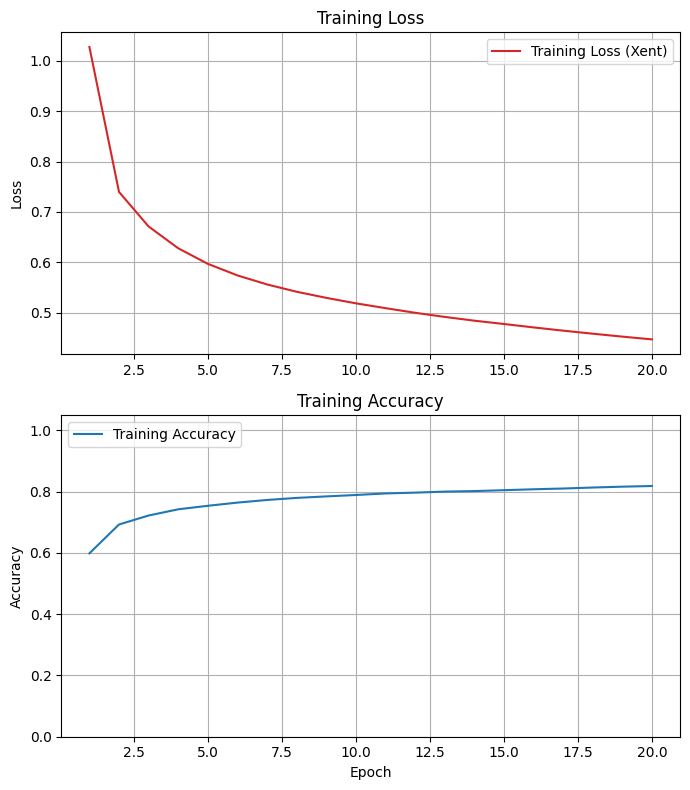

Final Training Loss:     0.4471
Final Training Accuracy: 0.8184

Plots for learning_rate = 0.0005:


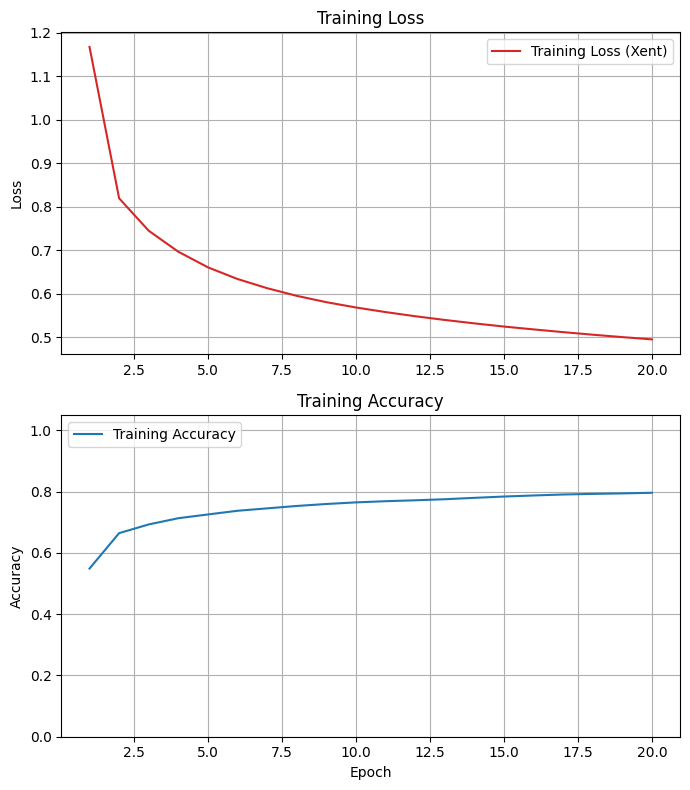

Final Training Loss:     0.4956
Final Training Accuracy: 0.7963

Plots for learning_rate = 0.0001:


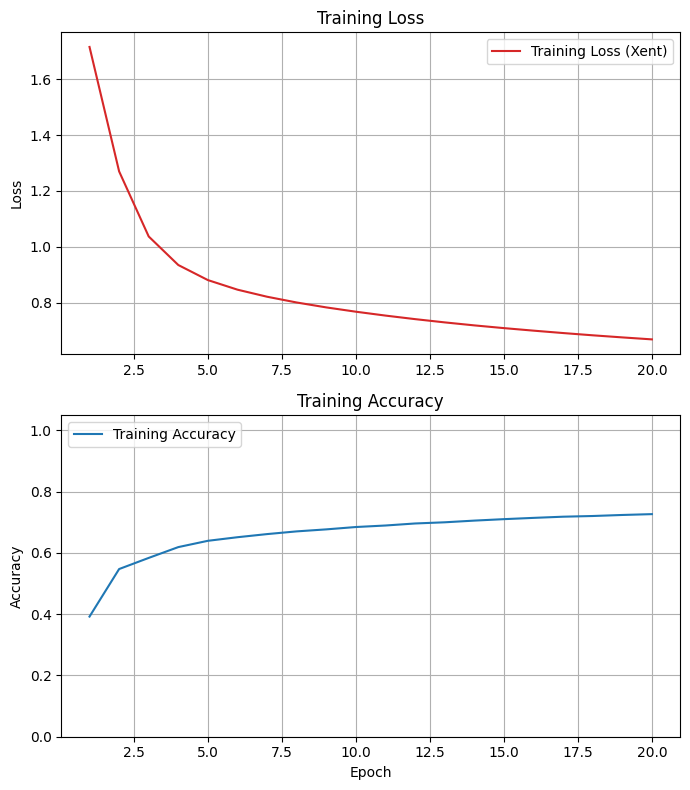

Final Training Loss:     0.6685
Final Training Accuracy: 0.7266

Plots for learning_rate = 5e-05:


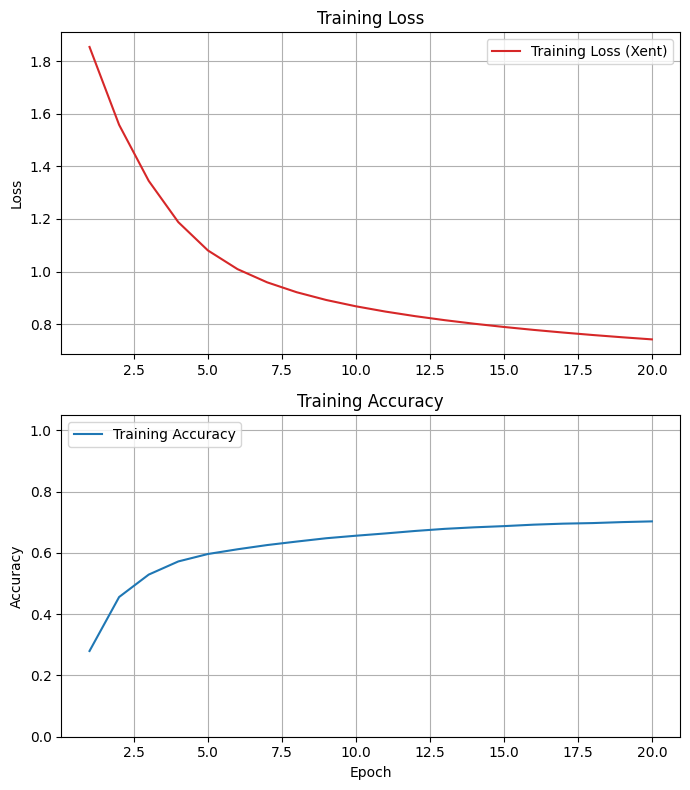

Final Training Loss:     0.7421
Final Training Accuracy: 0.7029

Plots for learning_rate = 1e-05:


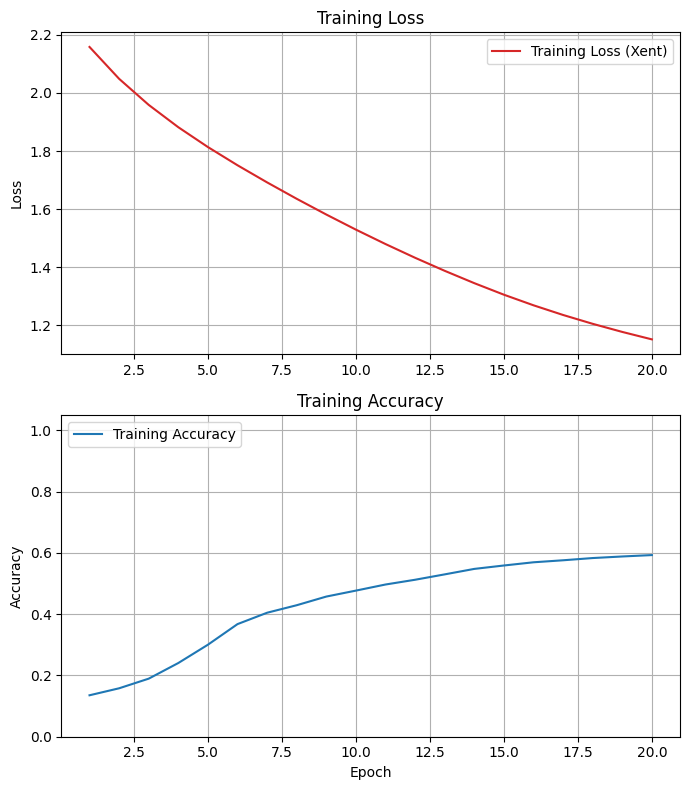

Final Training Loss:     1.1517
Final Training Accuracy: 0.5929

SUMMARY OF RESULTS
Learning rate    1e-03: Final accuracy = 0.8184
Learning rate    5e-04: Final accuracy = 0.7963
Learning rate    1e-04: Final accuracy = 0.7266
Learning rate    5e-05: Final accuracy = 0.7029
Learning rate    1e-05: Final accuracy = 0.5929

Best performing learning rate: 0.001
Best accuracy score: 0.8184


In [38]:
# Your code here

learning_rates = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]

results = {}
histories = {}
final_accuracies = {}

print("Starting learning rate experiments...")
print("=" * 50)

for lr in learning_rates:
    print(f"\nExperiment with learning_rate = {lr}")
    print("-" * 40)
    
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dense(32, activation='relu'),
        Dense(7, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    history = model.fit(
        X_train_scaled, y_train,
        epochs=20,
        batch_size=32,
        validation_data=(X_test_scaled, y_test),
        verbose=1
    )
    
    histories[lr] = history
    final_accuracy = history.history['accuracy'][-1]
    final_accuracies[lr] = final_accuracy
    
    print(f"Final training accuracy for learning_rate {lr}: {final_accuracy:.4f}")

print("\n" + "=" * 50)
print("All experiments completed")

print("\nPlotting training histories for all learning rates...")
for lr in learning_rates:
    print(f"\nPlots for learning_rate = {lr}:")
    plot_history(histories[lr])

best_lr = max(final_accuracies, key=final_accuracies.get)
best_accuracy = final_accuracies[best_lr]

print("\n" + "=" * 50)
print("SUMMARY OF RESULTS")
print("=" * 50)
for lr in learning_rates:
    accuracy = final_accuracies[lr]
    print(f"Learning rate {lr:8.0e}: Final accuracy = {accuracy:.4f}")

print(f"\nBest performing learning rate: {best_lr}")
print(f"Best accuracy score: {best_accuracy:.4f}")

In [39]:
# Set a3a to the learning rate which produces the best (largest) accuracy at epoch 20

a3a = 0.001             # Replace 0.0 with your answer

In [40]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3a = {a3a:.4f}') 

a3a = 0.0010


In [41]:
# Set a3b to the accuracy found by the best learning rate

a3b = 0.8184             # Replace 0.0 with your answer

In [42]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3b = {a3b:.4f}') 

a3b = 0.8184


## Problem Four: Cosine Decay Learning Rate Scheduling

In this problem we'll gain some experience using the Cosine Decay learning rate scheduler with Adam. 

* Start with the code from **Problem One**.
* Define a `CosineDecay` learning rate scheduler (see `Week02_Coding.ipynb` for details)
* Use the scheduler with the Adam optimzier
* Run **five experiments** using the following values for `initial_learning_rate`:

        [1e-2, 5e-3, 1e-3,5e-4, 1e-4]

* Display your results using `plot_history` and answer the graded questions.

Training configuration:
Training samples: 15383
Batch size: 32
Steps per epoch: 480
Total training steps: 9600

Starting Cosine Decay learning rate experiments...

Experiment with initial_learning_rate = 0.01
--------------------------------------------------
Using CosineDecay scheduler:
  - Initial learning rate: 0.01
  - Decay steps: 9600
  - Alpha (final LR factor): 0.0
Epoch 1/20


481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6579 - loss: 0.8243 - val_accuracy: 0.7176 - val_loss: 0.6800
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7190 - loss: 0.6705 - val_accuracy: 0.7410 - val_loss: 0.6242
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7374 - loss: 0.6270 - val_accuracy: 0.7366 - val_loss: 0.6282
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7498 - loss: 0.5964 - val_accuracy: 0.7540 - val_loss: 0.5826
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7656 - loss: 0.5603 - val_accuracy: 0.7712 - val_loss: 0.5706
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7799 - loss: 0.5309 - val_accuracy: 0.7777 - val_loss: 0.5450
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7928 - loss: 0.5052 - val_accuracy: 0.7930 - val_loss: 0.5116
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8018 - loss: 0.4783 - val_accuracy: 0.7975 - val_

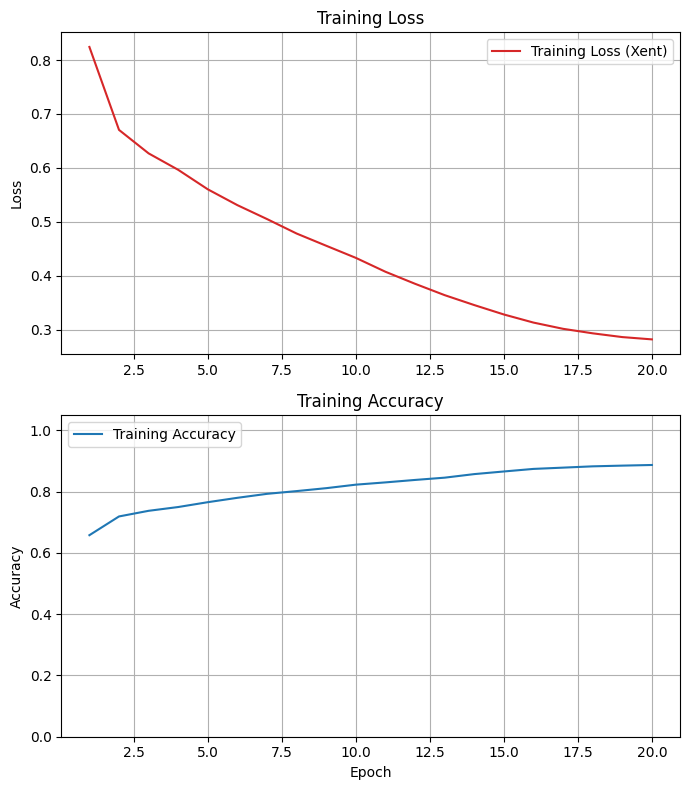

Final Training Loss:     0.2820
Final Training Accuracy: 0.8870

Plots for initial_learning_rate = 0.005:


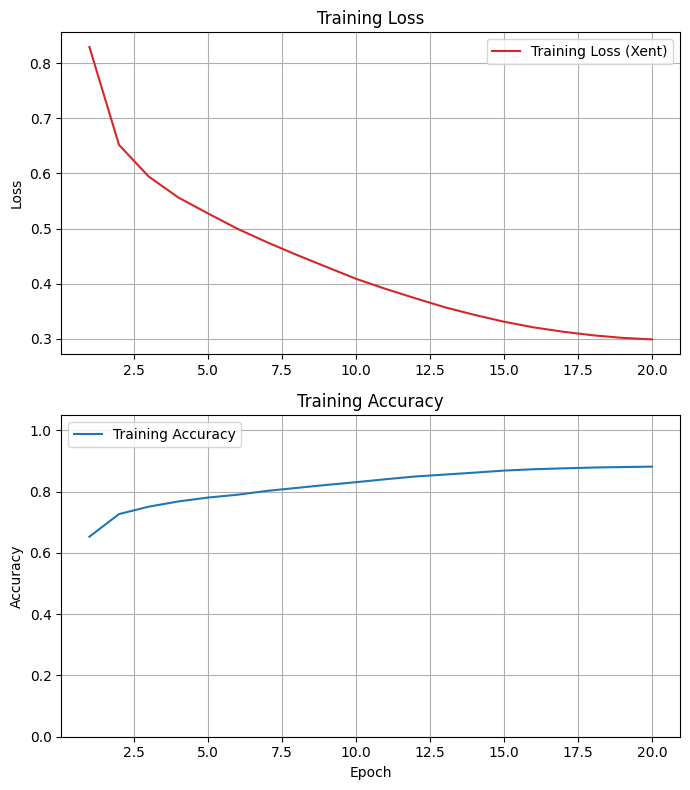

Final Training Loss:     0.2985
Final Training Accuracy: 0.8816

Plots for initial_learning_rate = 0.001:


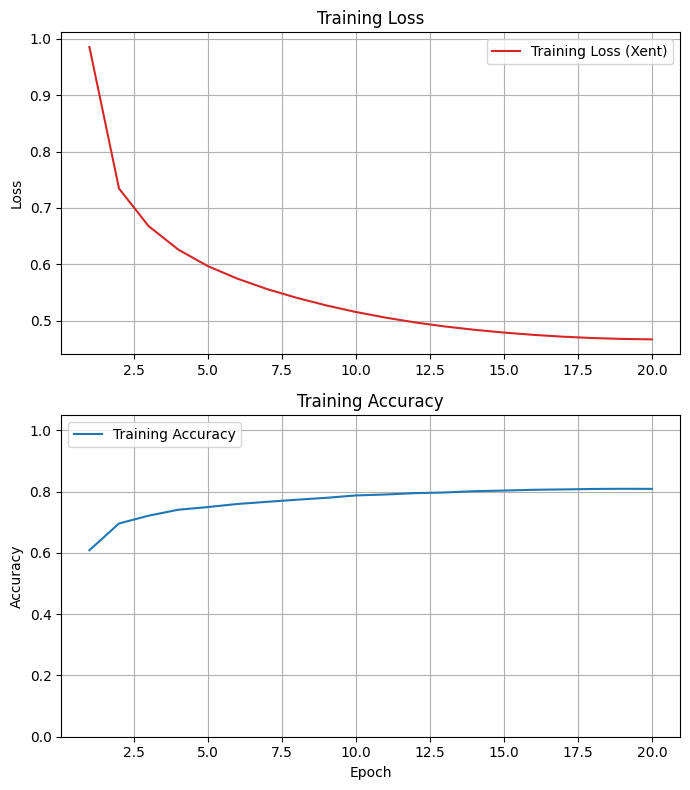

Final Training Loss:     0.4672
Final Training Accuracy: 0.8091

Plots for initial_learning_rate = 0.0005:


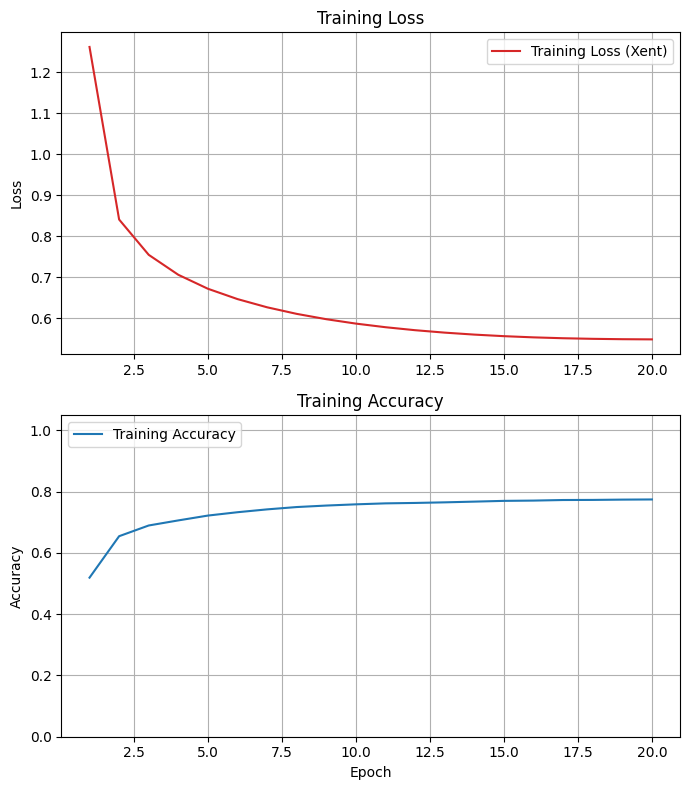

Final Training Loss:     0.5479
Final Training Accuracy: 0.7745

Plots for initial_learning_rate = 0.0001:


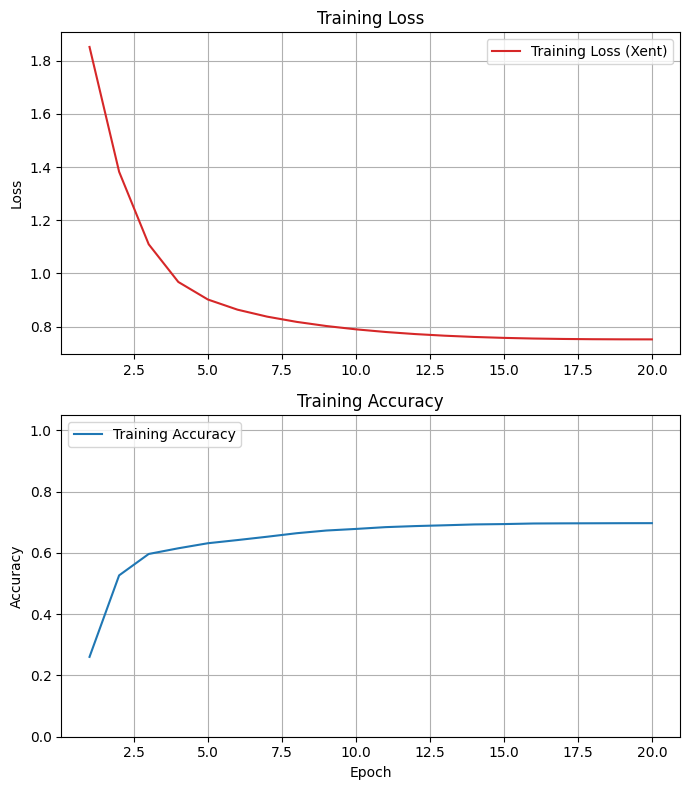

Final Training Loss:     0.7522
Final Training Accuracy: 0.6971

SUMMARY OF RESULTS
Initial LR    1e-02: Final accuracy = 0.8870
Initial LR    5e-03: Final accuracy = 0.8816
Initial LR    1e-03: Final accuracy = 0.8091
Initial LR    5e-04: Final accuracy = 0.7745
Initial LR    1e-04: Final accuracy = 0.6971

Best performing initial learning rate: 0.01
Best accuracy score: 0.8870


In [43]:
# Your code here

from tensorflow.keras.optimizers.schedules import CosineDecay

initial_learning_rates = [1e-2, 5e-3, 1e-3, 5e-4, 1e-4]

training_samples = X_train_scaled.shape[0]
batch_size = 32
epochs = 20
steps_per_epoch = training_samples // batch_size
total_steps = steps_per_epoch * epochs

print(f"Training configuration:")
print(f"Training samples: {training_samples}")
print(f"Batch size: {batch_size}")
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Total training steps: {total_steps}")

results = {}
histories = {}
final_accuracies = {}

print("\n" + "=" * 60)
print("Starting Cosine Decay learning rate experiments...")
print("=" * 60)

for initial_lr in initial_learning_rates:
    print(f"\nExperiment with initial_learning_rate = {initial_lr}")
    print("-" * 50)
    
    cosine_decay_scheduler = CosineDecay(
        initial_learning_rate=initial_lr,
        decay_steps=total_steps,
        alpha=0.0
    )
    
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dense(32, activation='relu'),
        Dense(7, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=cosine_decay_scheduler),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    print(f"Using CosineDecay scheduler:")
    print(f"  - Initial learning rate: {initial_lr}")
    print(f"  - Decay steps: {total_steps}")
    print(f"  - Alpha (final LR factor): 0.0")
    
    history = model.fit(
        X_train_scaled, y_train,
        epochs=20,
        batch_size=32,
        validation_data=(X_test_scaled, y_test),
        verbose=1
    )
    
    histories[initial_lr] = history
    final_accuracy = history.history['accuracy'][-1]
    final_accuracies[initial_lr] = final_accuracy
    
    print(f"Final training accuracy for initial_lr {initial_lr}: {final_accuracy:.4f}")

print("\n" + "=" * 60)
print("All experiments completed")

print("\nPlotting training histories for all initial learning rates...")
for initial_lr in initial_learning_rates:
    print(f"\nPlots for initial_learning_rate = {initial_lr}:")
    plot_history(histories[initial_lr])

best_initial_lr = max(final_accuracies, key=final_accuracies.get)
best_accuracy = final_accuracies[best_initial_lr]

print("\n" + "=" * 60)
print("SUMMARY OF RESULTS")
print("=" * 60)
for initial_lr in initial_learning_rates:
    accuracy = final_accuracies[initial_lr]
    print(f"Initial LR {initial_lr:8.0e}: Final accuracy = {accuracy:.4f}")

print(f"\nBest performing initial learning rate: {best_initial_lr}")
print(f"Best accuracy score: {best_accuracy:.4f}")

In [48]:
# Set a4a to the initial learning rate which produced the best accuracy

a4a = 0.01             # Replace 0.0 with your answer

In [49]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4a = {a4a:.4f}') 

a4a = 0.0100


In [50]:
# Set a4b to the best accuracy found

a4b = 0.8870             # Replace 0.0 with your answer

In [51]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4b = {a4b:.4f}') 

a4b = 0.8870


## Problem Five: Find the best model and run on the test set

In this final problem, you must consider all the experiments you've done and pick the
set of training hyperparameters which gives you the best accuracy after 20 epochs. Do not change the model architecture. 

Your choices are:

- Which batch size?
- Cosine Decay or constant learning rate?
    - If Cosine Decay, which initial learning rate?
    - If not, which constant learning rate?

* Display your results using `plot_history`
* Run your best model on the test set
* Answer the graded questions.


**OPTIONAL: change the model architecture (but use only dense layers) and try other learning rate schedulers (exponential, step, etc.)**


Step 1: Analyzing results from previous experiments...
--------------------------------------------------
best_batch_size_from_problem2 = 4
best_batch_accuracy2 = 0.7803
best_lr_from_problem3 = 0.0010
best_cosine_initial_lr = 0.0100
best_cosine_accuracy = 0.8870
best_lr_accuracy = 0.8184

Step 2: Determining best configuration...
--------------------------------------------------
Selected configuration:
  - Batch size: 32
  - Use Cosine Decay: True
  - Initial learning rate: 0.01

Step 3: Training final model with best hyperparameters...
--------------------------------------------------
Using CosineDecay: initial_lr=0.01, decay_steps=9600
Final model compiled successfully!

Training final model...
Epoch 1/20


481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6603 - loss: 0.8251 - val_accuracy: 0.7241 - val_loss: 0.6887
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7194 - loss: 0.6747 - val_accuracy: 0.7363 - val_loss: 0.6291
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7412 - loss: 0.6258 - val_accuracy: 0.7493 - val_loss: 0.5984
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7569 - loss: 0.5830 - val_accuracy: 0.7631 - val_loss: 0.5609
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7693 - loss: 0.5570 - val_accuracy: 0.7722 - val_loss: 0.5554
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7788 - loss: 0.5283 - val_accuracy: 0.7821 - val_loss: 0.5479
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7924 - loss: 0.5045 - val_accuracy: 0.7884 - val_loss: 0.5304
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8027 - loss: 0.4782 - val_accuracy: 0.7980 - val_

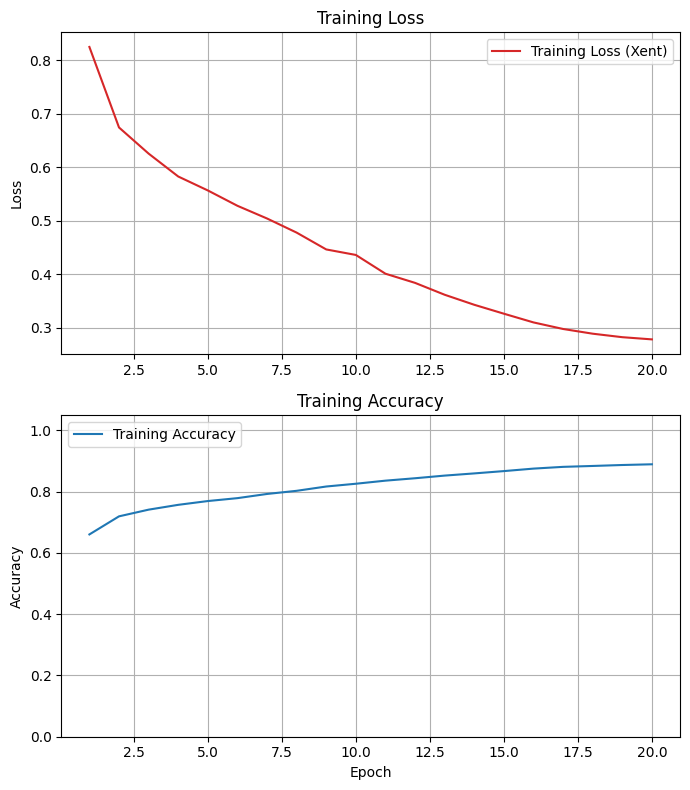

Final Training Loss:     0.2786
Final Training Accuracy: 0.8893

Step 5: Final evaluation on test set...
--------------------------------------------------
Final Results:
  - Best training accuracy: 0.8893
  - Test set accuracy: 0.8391
  - Test set loss: 0.4272


In [52]:
# Your code here -- add as many cells as you need

print("\nStep 1: Analyzing results from previous experiments...")
print("-" * 50)

best_batch_size_from_problem2 = 4 
best_batch_accuracy = 0.7803  

best_lr_from_problem3 = 0.0010  
best_lr_accuracy = 0.8184  

best_cosine_initial_lr = 0.0100  
best_cosine_accuracy = 0.8870  

print("best_batch_size_from_problem2 = 4") 
print("best_batch_accuracy2 = 0.7803") 
print("best_lr_from_problem3 = 0.0010")
print("best_cosine_initial_lr = 0.0100")
print("best_cosine_accuracy = 0.8870")
print("best_lr_accuracy = 0.8184")

print(f"\nStep 2: Determining best configuration...")
print("-" * 50)

BEST_BATCH_SIZE = 32  
BEST_USE_COSINE_DECAY = True 
BEST_INITIAL_LR = 0.0100  
BEST_CONSTANT_LR = 0.0010  

print(f"Selected configuration:")
print(f"  - Batch size: {BEST_BATCH_SIZE}")
print(f"  - Use Cosine Decay: {BEST_USE_COSINE_DECAY}")
if BEST_USE_COSINE_DECAY:
    print(f"  - Initial learning rate: {BEST_INITIAL_LR}")
else:
    print(f"  - Constant learning rate: {BEST_CONSTANT_LR}")

print(f"\nStep 3: Training final model with best hyperparameters...")
print("-" * 50)

final_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(7, activation='softmax')
])

if BEST_USE_COSINE_DECAY:
    training_samples = X_train_scaled.shape[0]
    steps_per_epoch = training_samples // BEST_BATCH_SIZE
    total_steps = steps_per_epoch * 20
    
    learning_rate_schedule = CosineDecay(
        initial_learning_rate=BEST_INITIAL_LR,
        decay_steps=total_steps,
        alpha=0.0
    )
    optimizer = Adam(learning_rate=learning_rate_schedule)
    print(f"Using CosineDecay: initial_lr={BEST_INITIAL_LR}, decay_steps={total_steps}")
else:
    optimizer = Adam(learning_rate=BEST_CONSTANT_LR)
    print(f"Using constant learning rate: {BEST_CONSTANT_LR}")

final_model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Final model compiled successfully!")

print(f"\nTraining final model...")
final_history = final_model.fit(
    X_train_scaled, y_train,
    epochs=20,
    batch_size=BEST_BATCH_SIZE,
    validation_data=(X_test_scaled, y_test),
    verbose=1
)

print("Training completed!")

print(f"\nStep 4: Displaying training results...")
print("-" * 50)
plot_history(final_history)

print(f"\nStep 5: Final evaluation on test set...")
print("-" * 50)

final_training_accuracy = final_history.history['accuracy'][-1]

test_loss, test_accuracy = final_model.evaluate(X_test_scaled, y_test, verbose=0)

print(f"Final Results:")
print(f"  - Best training accuracy: {final_training_accuracy:.4f}")
print(f"  - Test set accuracy: {test_accuracy:.4f}")
print(f"  - Test set loss: {test_loss:.4f}")

In [55]:
# Set a5a to the best training accuracy found by your best model

a5a = 0.8893             # Replace 0.0 with your answer

In [56]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5a = {a5a:.4f}') 

a5a = 0.8893


In [53]:
# Set a5b to the test accuracy found by your best model

a5b = 0.8391            # Replace 0.0 with your answer

In [54]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5b = {a5b:.4f}') 

a5b = 0.8391


## Reflection Questions (ungraded)

1. We trained on a perfectly balanced \~3.3% subset.
   If we *increase the subset size* (still balanced), how would you expect (a) training time, (b) the best **batch size**, and (c) the best **learning rate** to change? Why?

2. **Batch size trade-offs.**
   With epochs fixed, why do smaller batches often generalize better on tabular data than large batches? What would you change if you *must* use a large batch?

3. **More epochs, same LR.**
    If you doubled the number of epochs (no other changes), what do you think would happen to train loss/acc and test acc? 

4. **Epochs vs. LR.**
   It is natural to think that there is an inverse relationship between the number of epochs and learning rate: if you move more slowly, it will take you longer to reach your goal. Does this seem true given what we have seen in the experiments with learning rate?

# Appendix:  Forest Cover Type (Covertype) — Dataset Overview

This dataset pairs **cartographic features** of 30×30 m land plots with the **dominant tree cover type**. Your task is to predict the cover type from terrain and soil indicators—an archetypal **multi-class classification** problem on tabular data.

**At a glance**

* **Samples:** 581,012 original; we’ll use a **balanced subset** (e.g., 2747 per class) for faster, fairer training.
* **Features (54 total):**

  * **10 continuous:** elevation, aspect, slope, distances to hydrology/roads/fire points, and hillshade at 9 AM/noon/3 PM.
  * **44 binary:** **4 Wilderness\_Area** flags and **40 Soil\_Type** one-hot indicators.
* **Target (7 classes):** Spruce/Fir, Lodgepole Pine, Ponderosa Pine, Cottonwood/Willow, Aspen, Douglas-fir, Krummholz.

**Why it’s useful here**

* Realistic, **tabular** data with mixed feature types.
* Clear demonstration of **scaling** (continuous features) vs. **binary indicators**.
* Originally **imbalanced**, which motivates mindful evaluation (we avoid this by using a balanced subset).


Shape: (19229, 55)

Class distribution:
 Cover_Type
3    0.142857
2    0.142857
6    0.142857
5    0.142857
4    0.142857
1    0.142857
0    0.142857
Name: proportion, dtype: float64


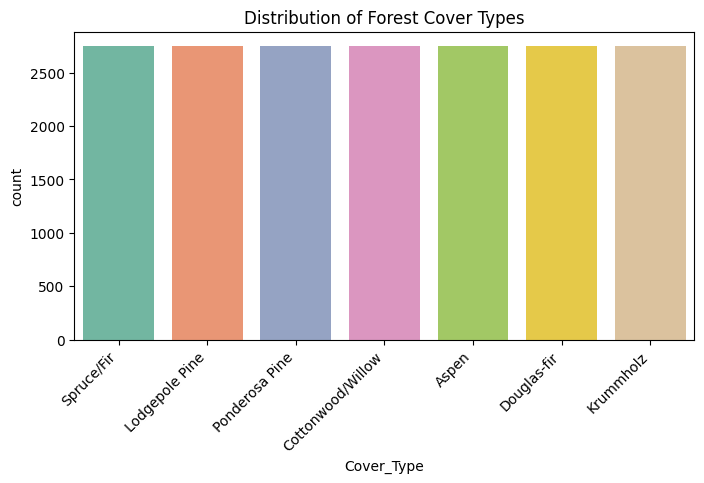

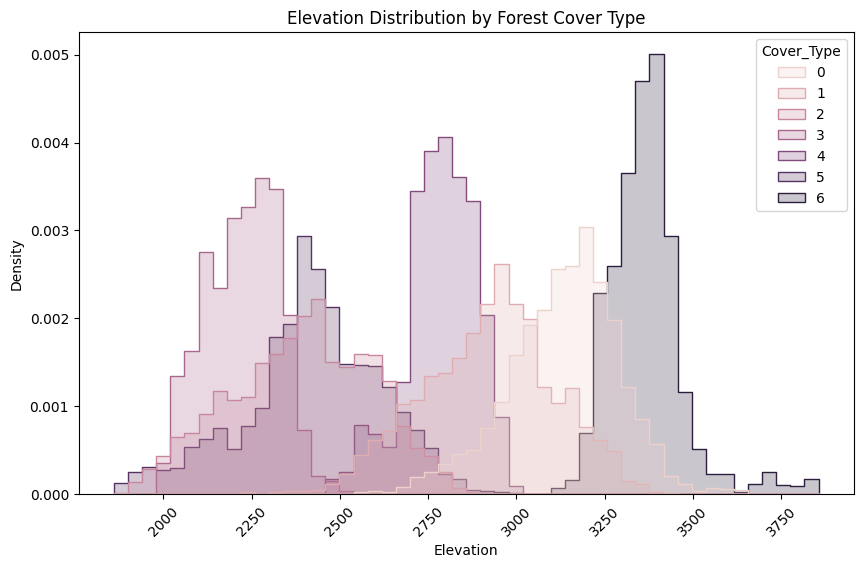

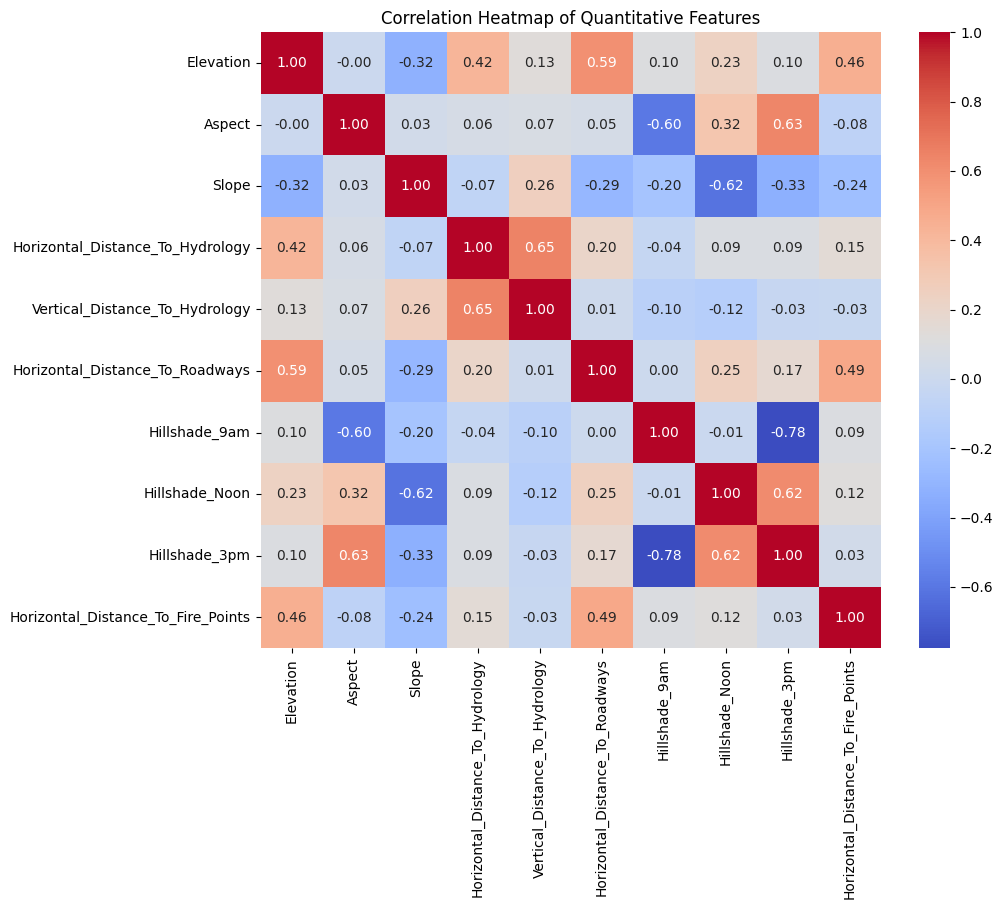

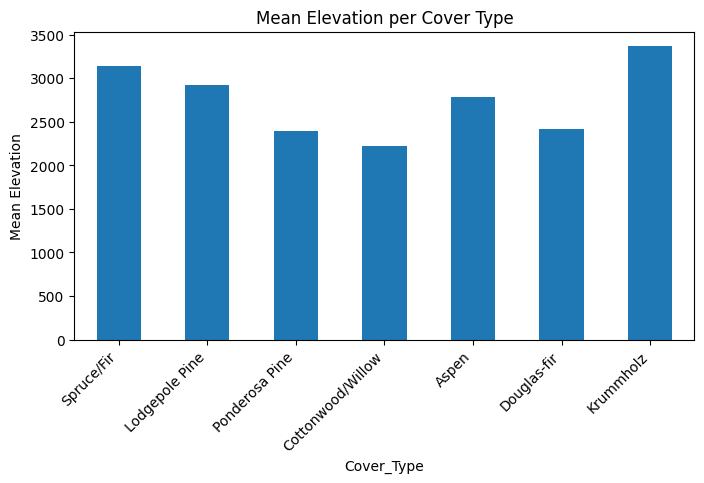

In [57]:
# Attach feature + class names
quant_features = [
    "Elevation", "Aspect", "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"
]
wilderness_features = [f"Wilderness_Area{i}" for i in range(1, 5)]
soil_features = [f"Soil_Type{i}" for i in range(1, 41)]

feature_names = quant_features + wilderness_features + soil_features
class_names = [
    "Spruce/Fir", "Lodgepole Pine", "Ponderosa Pine",
    "Cottonwood/Willow", "Aspen", "Douglas-fir", "Krummholz"
]

# Create dataframe from your subset
df = pd.DataFrame(X_sub, columns=feature_names)
df["Cover_Type"] = y_sub

# 1. Basic info
print("Shape:", df.shape)
print("\nClass distribution:\n", df["Cover_Type"].value_counts(normalize=True))

# 2. Class distribution plot
plt.figure(figsize=(8,4))
sns.countplot(x="Cover_Type", hue="Cover_Type", data=df, palette="Set2", legend=False)
plt.xticks(ticks=range(7), labels=class_names, rotation=45, ha="right")
plt.title("Distribution of Forest Cover Types")
plt.show()

# 3. Elevation distribution by class
plt.figure(figsize=(10,6))
sns.histplot(data=df, x="Elevation", hue="Cover_Type",
             bins=50, element="step", stat="density", common_norm=False)
plt.xticks(rotation=45)
plt.title("Elevation Distribution by Forest Cover Type")
plt.show()

# 4. Correlation heatmap (quantitative features only)
plt.figure(figsize=(10,8))
corr = df[quant_features].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Quantitative Features")
plt.show()

# 5. Mean elevation per cover type
df.groupby("Cover_Type")["Elevation"].mean().plot(kind="bar", figsize=(8,4))
plt.xticks(ticks=range(7), labels=class_names, rotation=45, ha="right")
plt.ylabel("Mean Elevation")
plt.title("Mean Elevation per Cover Type")
plt.show()
